# Evolution

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 11

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [67]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from thinkstats2 import Cdf
from thinkstats2 import RandomSeed

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

In [233]:
class FitnessLandscape:
    def __init__(self, N):
        """Create a fitness landscape.
        
        N: number of dimensions
        """
        self.N = N
        self.one_values = np.random.random(N)
        self.zero_values = np.random.random(N)

    def random_loc(self):
        """Choose a random location."""
        # in NumPy versions prior to 1.11, you might need
        #return np.random.randint(2, size=self.N).astype(np.int8)
        return np.random.randint(2, size=self.N, dtype=np.int8)
    
    def fitness(self, loc):
        """Evaluates the fitness of a location.
        
        loc: array of N 0s and 1s
        
        returns: float fitness
        """
        fs = np.where(loc, self.one_values, self.zero_values)
        return fs.mean()

In [234]:
fit_land = FitnessLandscape(5)
fit_land

In [235]:
fit_land.one_values, fit_land.zero_values

(array([ 0.294665  ,  0.53058676,  0.19152079,  0.06790036,  0.78698546]),
 array([ 0.65633352,  0.6375209 ,  0.57560289,  0.03906292,  0.3578136 ]))

In [236]:
loc = fit_land.random_loc()
loc, fit_land.fitness(loc)

(array([0, 1, 0, 0, 0], dtype=int8), 0.43187993836131983)

In [237]:
np.where(loc, fit_land.one_values, fit_land.zero_values)

array([ 0.65633352,  0.53058676,  0.57560289,  0.03906292,  0.3578136 ])

In [238]:
loc, fit_land.fitness(loc)

(array([0, 1, 0, 0, 0], dtype=int8), 0.43187993836131983)

In [239]:
loc = fit_land.random_loc()
loc, fit_land.fitness(loc)

(array([1, 0, 1, 1, 1], dtype=int8), 0.39571850077388898)

## The agents



In [240]:
class Agent:
    """Represents an agent in an NK model."""
    
    def __init__(self, loc, fit_land):
        """Create an agent at the given location.
        
        loc: array of N 0s and 1s
        fit_land: reference to an fit_land
        """
        self.loc = loc
        self.fit_land = fit_land
        self.fitness = fit_land.fitness(self.loc)
        
    def copy(self):
        return Agent(self.loc, self.fit_land)

In [241]:
loc = fit_land.random_loc()
agent = Agent(loc, fit_land)
agent.loc, agent.fitness

(array([0, 1, 1, 1, 1], dtype=int8), 0.44666537650396981)

## The simulator



In [242]:
class Simulation:
    
    def __init__(self, fit_land, agents):
        """Create the simulation:
        
        fit_land: fit_land
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.fit_land = fit_land
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: Instrument object
        """
        self.instruments.append(instrument)
        
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=500):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        n = len(self.agents)
        fits = self.get_fitnesses()
        
        # see who dies
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements

        # update any instruments
        self.update_instruments()
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, fits):
        """Choose which agents die in the next timestep.
        
        fits: array of fitnesses
        p: probability of survival
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < 0.1
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
        
    def choose_replacements(self, n, fits):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        fits: array of fitnesses
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [243]:
def make_random_agents(fit_land, num_agents, agent_maker):
    """Make a Simulation object.
    
    fit_land: FitnessLandscape
    num_agents: integer
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    locs = [fit_land.random_loc() for _ in range(num_agents)]
    agents = [agent_maker(loc, fit_land) for loc in locs]
    return agents

In [244]:
def make_all_agents(fit_land, num_agents, agent_maker):
    """Make a Simulation object.
    
    fit_land: FitnessLandscape
    num_agents: integer
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    assert fit_land.N == 8
    
    array = np.arange(num_agents, dtype=np.uint8)
    locs = np.unpackbits(array[:, None], axis=1)
    agents = [agent_maker(loc, fit_land) for loc in locs]
    return agents

In [255]:
RandomSeed(17)
N = 8
fit_land = FitnessLandscape(N)
agents = make_all_agents(fit_land, 2**N, Agent)
sim = Simulation(fit_land, agents)

In [256]:
def plot_fitnesses(sim):
    """Plot the CDF of fitnesses.
    
    sim: Simulation object
    """
    fits = sim.get_fitnesses()
    cdf_fitness = Cdf(fits)
    thinkplot.Cdf(cdf_fitness)
    return np.mean(fits)

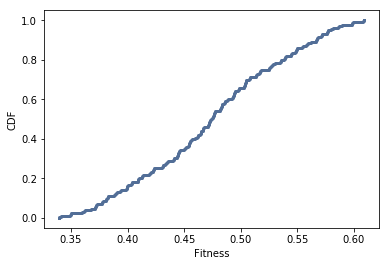

In [257]:
plot_fitnesses(sim)
thinkplot.Config(xlabel='Fitness', ylabel='CDF')

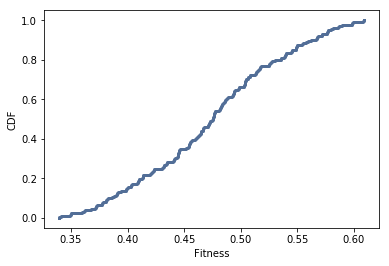

In [258]:
sim.step()
plot_fitnesses(sim)
thinkplot.Config(xlabel='Fitness', ylabel='CDF')

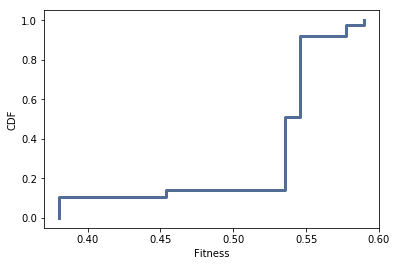

In [259]:
sim.run()
plot_fitnesses(sim)
thinkplot.Config(xlabel='Fitness', ylabel='CDF')

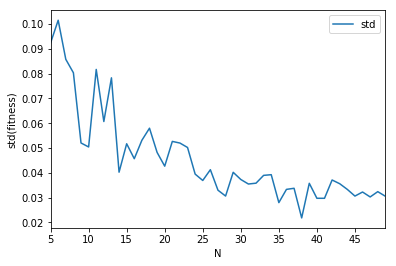

In [260]:
series = pd.Series([])

for N in range(5, 50):
    fit_land = FitnessLandscape(N)
    sim = make_simulation(fit_land, 100, Agent, Simulation)
    std = np.std(sim.get_fitnesses())
    series[N] = std
    
series.plot(label='std')
thinkplot.Config(xlabel='N', ylabel='std(fitness)')

In [261]:
class Instrument:
    """Computes a metric at each timestep."""
    
    def __init__(self):
        self.metrics = []
        
    def update(self, sim):
        """Compute the current metric.
        
        Appends to self.metrics.
        
        sim: Simulation object
        """
        pass
        
    def plot(self, *args, **kwargs):
        thinkplot.plot(self.metrics, *args, **kwargs)

In [262]:
class MeanFitness(Instrument):
    """Computes mean fitness at each timestep."""
    
    def update(self, sim):
        mean = np.mean(sim.get_fitnesses())
        self.metrics.append(mean)

In [274]:
def plot_sims(sim_maker, instrument_maker, color='blue'):
    for _ in range(10):
        sim = sim_maker(fit_land, agents)
        sim.add_instrument(instrument_maker())
        sim.run()
        sim.plot(0, color=color, alpha=0.3)
    thinkplot.Config(xlabel='Time', ylabel='Mean fitness')

In [277]:
RandomSeed(17)
plot_sims(Simulation, MeanFitness, 'blue')
thinkplot.Save('chap11-1')

Writing chap11-1.pdf
Writing chap11-1.png


In [265]:
class SimWithDiffSurvival(Simulation):
    
    def choose_dead(self, fits):
        """Choose which agents die in the next timestep.
        
        fits: sequence of fitnesses
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) > fits
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

In [278]:
RandomSeed(17)
plot_sims(SimWithDiffSurvival, MeanFitness, 'green')
thinkplot.Save('chap11-2')

Writing chap11-2.pdf
Writing chap11-2.png


In [267]:
class SimWithDiffReproduction(Simulation):

    def choose_replacements(self, n, fits):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        fits: sequence of fitnesses
        
        returns: sequence of Agent objects
        """
        p = fits / np.sum(fits)
        agents = np.random.choice(self.agents, size=n, replace=True, p=p)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [279]:
RandomSeed(17)
plot_sims(SimWithDiffReproduction, MeanFitness, 'purple')
thinkplot.Save('chap11-3')

Writing chap11-3.pdf
Writing chap11-3.png


**Exercise:** What if you have both?

In [269]:
class SimWithBoth(Simulation):
    choose_dead = SimWithDiffSurvival.choose_dead
    choose_replacements = SimWithDiffReproduction.choose_replacements

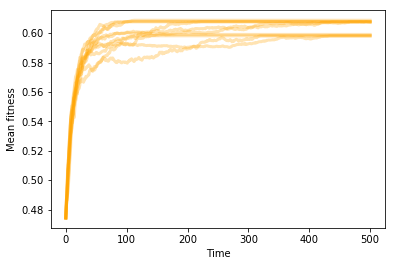

In [270]:
RandomSeed(17)
plot_sims(SimWithBoth, MeanFitness, 'orange')  

In [272]:
class UniqueAgents(Instrument):
    
    def update(self, sim):
        uniq_agents = len(set(sim.get_locs()))
        self.metrics.append(uniq_agents)

In [280]:
RandomSeed(17)
plot_sims(Simulation, UniqueAgents, 'blue')
thinkplot.Save('chap11-4')

Writing chap11-4.pdf
Writing chap11-4.png


In [281]:
RandomSeed(17)
plot_sims(SimWithDiffSurvival, UniqueAgents, 'green')
thinkplot.Save('chap11-5')

Writing chap11-5.pdf
Writing chap11-5.png


**Exercise:** What about DiffRepro?

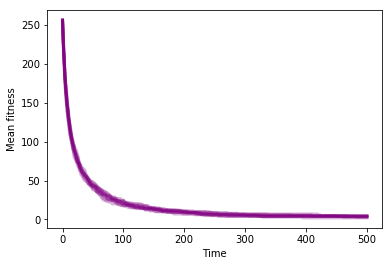

In [282]:
RandomSeed(17)
plot_sims(SimWithDiffReproduction, UniqueAgents, 'purple')

## Mutation

In [284]:
class Mutant(Agent):
    
    prob_mutate = 0.05
    
    def copy(self):
        if np.random.random() > self.prob_mutate:
            loc = self.loc.copy()
        else:
            direction = np.random.randint(self.fit_land.N)
            loc = self.mutate(direction)
        return Mutant(loc, self.fit_land)
    
    def mutate(self, direction):
        """Computes the location in the given direction.
        
        Result differs from the current location along the given axis.
        
        direction: int index from 0 to N-1
        
        returns: new array of N 0s and 1s
        """
        new_loc = self.loc.copy()
        new_loc[direction] ^= 1
        return new_loc

In [285]:
loc = fit_land.random_loc()
agent = Mutant(loc, fit_land)
agent.loc

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0], dtype=int8)

In [286]:
for i in range(20):
    copy = agent.copy()
    print(agent.loc == copy.loc)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  T

In [34]:
fit_land = FitnessLandscape(5)
sim = Simulation2(fit_land, 100, Mutant)

for i in range(50):
    sim.step()

NameError: name 'Simulation2' is not defined

In [ ]:
thinkplot.plot(sim.uniq_agents)

Here's how the distribution of fitness evolves after each step.

In [ ]:
thinkplot.PrePlot(7)

sim = Simulation(fit_land, 100, AgentFitter)

for i in range(7):
    cdf_fitness = Cdf(sim.get_fitnesses())
    thinkplot.Cdf(cdf_fitness)
    sim.step()

After every agent has found a peak, we can plot the distribution of fitness.

In [ ]:
cdf_fitness = Cdf(sim.get_fitnesses())
thinkplot.Cdf(cdf_fitness)

The number of unique locations is a lower bound on the number of peaks.

In [ ]:
peaks = sim.get_peaks()
len(peaks)

And we can look at the heights of the peaks.

In [ ]:
heights = sim.get_peak_heights()
heights

Here's the distribution of path lengths.  A few agents are born on a peak.  The longest path is probably 5 or fewer.

In [ ]:
cdf_moves = Cdf(sim.get_path_lengths())
thinkplot.Cdf(cdf_moves)

This function encapsulates the steps for running a simulation:

In [ ]:
def run_simulation(N=5, K=2, num_agents=100, agent_maker=AgentFitter):
    """Create a simulation and run until all agents find a peak.
    
    N: int number of traits
    K: int number of interactions
    num_agents: int number of agents
    agent_maker: function that creates agents
    
    returns Simulation object
    """
    fit_land = fit_land(N, K)
    sim = Simulation(fit_land, num_agents, agent_maker)
    for i in range(100):
        steps = sim.step()
        if np.sum(steps) == 0:
            break
    return sim

Here's the same small example:

In [ ]:
sim = run_simulation(N=5, K=2)

This function takes a completed simulation and summarizes the results.

In [ ]:
def plot_results(sim):
    """Summarizes simulation results.
    
    sim: Simulation object
    """
    cdf_fitness = Cdf(sim.get_fitnesses())
    peaks = sim.get_peaks()
    heights = sim.get_peak_heights()
    cdf_moves = Cdf(sim.get_path_lengths())
    
    print("Mean fitness: ", cdf_fitness.Mean())
    print("Mean path length: ", cdf_moves.Mean())
    print("Number of peaks:", len(peaks))

    thinkplot.PrePlot(cols=2)
    thinkplot.Cdf(cdf_fitness)
    thinkplot.Config(xlabel='Fitness', ylabel='CDF')

    thinkplot.SubPlot(2)
    thinkplot.Cdf(cdf_moves)
    thinkplot.Config(xlabel='Path Length', ylabel='CDF')

And here are the result with small values of `N` and `K`.

In [ ]:
plot_results(sim)

Here's a simulation run with larger `N` and `K`:

In [ ]:
%time sim = run_simulation(N=40, K=20)
plot_results(sim)

**Exercise:** Starting with `N=5` and `K=3`, run simulations with increasing values of `N`, keeping `K` constant, and plot the number of peaks and mean path length as a function of `N`.

In [ ]:
# Solution

K = 3
res = []

ns = range(5, 30)
for N in ns:
    sim = run_simulation(N, K)
    num_peaks = len(sim.get_peaks())
    mean_path = np.mean(sim.get_path_lengths())
    res.append((num_peaks, mean_path))
    
peaks, paths = np.transpose(res)

In [ ]:
# Solution

thinkplot.Plot(ns, peaks)
thinkplot.Config(xlabel='N', ylabel='Number of peaks')

In [ ]:
# Solution

thinkplot.Plot(ns, paths)
thinkplot.Config(xlabel='N', ylabel='Mean path length')

**Exercise:** Starting with `N=20` and `K=0`, run simulations with increasing values of `K`, keeping `N` constant, and plot the number of peaks and mean path length as a function of `K`.

In [ ]:
# Solution

N = 20
res = []

ks = range(0, 20)
for K in ks:
    sim = run_simulation(N, K)
    num_peaks = len(sim.get_peaks())
    mean_path = np.mean(sim.get_path_lengths())
    res.append((num_peaks, mean_path))
    
peaks, paths = np.transpose(res)

In [ ]:
# Solution

thinkplot.Plot(ks, peaks)
thinkplot.Config(xlabel='N', ylabel='Number of peaks')

In [ ]:
# Solution

thinkplot.Plot(ks, paths)
thinkplot.Config(xlabel='N', ylabel='Mean path length')